In [1]:
import rasterio as ro
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random
import math
import pandas
from scipy import optimize

#from keras_tuner.engine.hyperparameters import HyperParameters

from scipy.signal import savgol_filter

In [2]:
# load the data
ndvi = ro.open("Data/NDVI.grd")

covariates = ro.open("Data/covariates_250m_peninsula.grd")

p1 = ro.open("Data/newprec_01.tif")

p7 = ro.open("Data/newprec_07.tif")

fire_history = ro.open("Data/age.grd")

qa_data = ro.open("Data/QA.grd")

In [3]:
# read the shape of covariates
covariates_arr = covariates.read()

np.shape(covariates_arr)

(12, 172, 63)

In [4]:
# read the shape of NDVI
ndvi_arr = ndvi.read()

np.shape(ndvi_arr)

(748, 172, 63)

In [5]:
# read the shape of QA
qa_arr = qa_data.read()

np.shape(qa_arr)

(748, 172, 63)

In [6]:
# read the shape of fire history
fire_arr = fire_history.read()

np.shape(fire_arr)

(748, 172, 63)

In [7]:
# read the precipitation data
p1_arr = p1.read()
p1_arr.shape
p7_arr = p7.read()
p7_arr.shape

p1_arr = p1_arr[:,:172,:63]

p7_arr = p7_arr[:,:172,:63]

In [8]:
p1_arr.shape

(1, 172, 63)

In [9]:
# replace the negative value with nan data in precipitation
for m in range(0,172):
  for n in range(0,63):
    if p1_arr[:,m,n] < 0 :
      p1_arr[:,m,n] = np.nan
    else:
      pass


for m in range(0,172):
  for n in range(0,63):
    if p7_arr[:,m,n] < 0 :
      p7_arr[:,m,n] = np.nan
    else:
      pass

In [10]:
# replace the precipitation value
covariates_arr[9] = p1_arr
covariates_arr[10] = p7_arr

In [11]:
# read the shape of new covariates 
np.shape(covariates_arr)

(12, 172, 63)

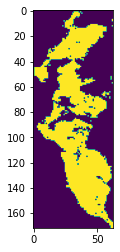

In [12]:
# create a mask based on the environmental variables and fire history
study_region_mask = np.zeros((ndvi.height,ndvi.width))


for i in range(study_region_mask.shape[0]):
    for j in range(study_region_mask.shape[1]):
        found_nan = False
        for var_index in range(covariates_arr.shape[0]):
            if np.isnan(covariates_arr[var_index,i,j]):
                found_nan =True
                break

        for time_step in range(fire_arr.shape[0]):
            if np.isnan(fire_arr[time_step,i,j]):
                found_nan =True
                break
        
        if found_nan:
            study_region_mask[i,j] = -1
        else:
            study_region_mask[i,j] = 1

plt.imshow(study_region_mask)

In [13]:
nan_value = 0

In [14]:
# a mask out function
def mask_layer(input_layer, mask_layer):
    for i in range(mask_layer.shape[0]):
        for j in range(mask_layer.shape[1]):
            if mask_layer[i,j]==-1:
                input_layer[i,j] = nan_value # replace the nan value in the input data

    return input_layer

In [15]:
#savgol_filter to smooth the data
#ndvi_times = range(1,ndvi.count+1)

qa_value_array = qa_data.read()

ndvi_smoothed = []

for m in range(0,ndvi.height):
  for n in range(0,ndvi.width):

    ndvi_ori = ndvi_arr[:,m,n]
    
    if study_region_mask[m,n] ==-1:
      ndvi_smoothed.append(ndvi_ori)
      continue
    
    
    qa_value = qa_arr[:,m,n]
    # for i in ndvi_times:
    #   ndvi_data = ndvi.read(i)
    #   ndvi_pixel = ndvi_data[m,n]
    #   ndvi_ori.append(ndvi_pixel) 


    #   qa = qa_data.read(i)
    #   qa_pixel = qa[m,n]
    #   qa_value.append(qa_pixel) 

    smoothed = savgol_filter(ndvi_ori,7,2)

    for t in range(qa_value.shape[0]):
      if qa_value[t] == 0 and ndvi_ori[t]>0:
        smoothed[t] = ndvi_ori[t]
      # else:
      #   pass

    ndvi_smoothed.append(smoothed)


ndvi_smoothed = np.asarray(ndvi_smoothed)

In [16]:
np.shape(ndvi_smoothed)

(10836, 748)

In [17]:
# created the dataset contains ONLY SMOOTHED NDVI DATA
smoothed_dataset = np.zeros((ndvi.count,ndvi.height,ndvi.width,1))
for time_steps in range(0,ndvi.count):
  for m in range(0,ndvi.height):
    for n in range(0,ndvi.width):
      smoothed_dataset[time_steps,m,n,0] = ndvi_smoothed[63*m+n][time_steps]

print(np.shape(smoothed_dataset))

(748, 172, 63, 1)


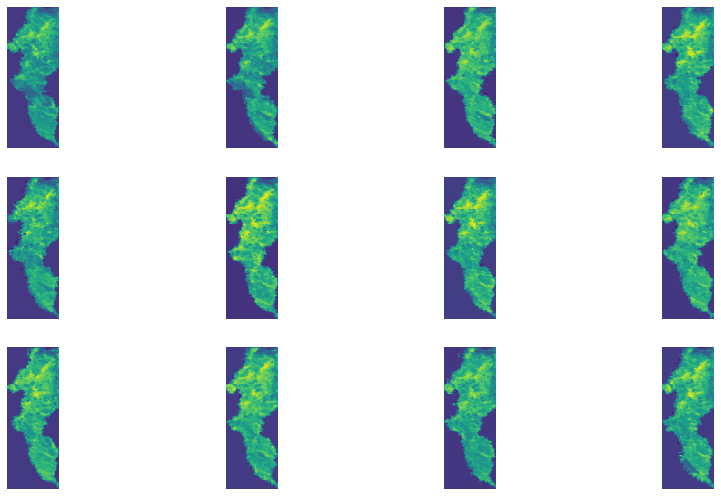

In [18]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(smoothed_dataset[random_time,:,:,0])
    plt.axis('off')

In [19]:
# filter the SMOOTHED DATA with the mask

for time_steps in range(0,smoothed_dataset.shape[0]):
    smoothed_dataset[time_steps,:,:,:] = mask_layer(smoothed_dataset[time_steps,:,:,:],study_region_mask)


print(np.shape(smoothed_dataset))

(748, 172, 63, 1)


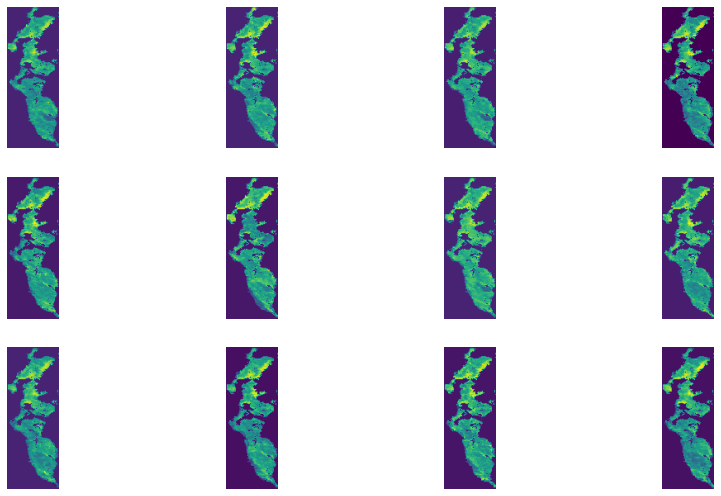

In [20]:
# visualize random 12 NDVI values of SMOOTHED and masked NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(smoothed_dataset[random_time,:,:,0])
    plt.axis('off')

convLSTM part

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [22]:
#!!pip install tensorflow

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2022-07-26 02:46:08.500082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-26 02:46:08.919692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-07-26 02:46:08.990279: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-26 02:46:10.120919: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-26 02:46:10.623037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-26 02:46:10.961423: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-

Num GPUs Available:  0


In [24]:
tf.random.set_seed(42)

In [25]:


def create_model():
    tf.random.set_seed(42)
    np.random.seed(42)

    model = keras.Sequential(
        [
            layers.SimpleRNN(541,return_sequences = True,input_shape=[None, 172*63]),
            layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541,return_sequences = True),
            #layers.SimpleRNN(541),

            layers.TimeDistributed(keras.layers.Dense(172*63))
            #layers.Dense(172*63)#, activation="linear")
        ]
    )
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    return model


In [26]:
"""
def create_model():
    tf.random.set_seed(42)

    convLSTM_model = keras.Sequential(
        [
            #keras.Input(shape=(None, 172, 63, 1)),  # Variable-length sequence of 172x63x1 frames
            #layers.InputLayer(input_shape=( ,162540, 1)),
            #layers.Flatten(in),
            layers.SimpleRNN(4000,return_sequences = True,input_shape=[None, 172*63]),
            #layers.BatchNormalization(),
            layers.SimpleRNN(4000,return_sequences = True),
            #layers.BatchNormalization(),
            layers.SimpleRNN(2000,return_sequences = True),
            #layers.BatchNormalization(),
            layers.SimpleRNN(1000,return_sequences = True),
            #layers.BatchNormalization(),
            keras.layers.TimeDistributed(keras.layers.Dense(172*63, activation="linear")) 
            #keras.layers.TimeDistributed(keras.layers.Dense(1))
            #layers.Dense(172*63, activation="linear")
        ]
    )
    convLSTM_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
    return convLSTM_model

"""

'\ndef create_model():\n    tf.random.set_seed(42)\n\n    convLSTM_model = keras.Sequential(\n        [\n            #keras.Input(shape=(None, 172, 63, 1)),  # Variable-length sequence of 172x63x1 frames\n            #layers.InputLayer(input_shape=( ,162540, 1)),\n            #layers.Flatten(in),\n            layers.SimpleRNN(4000,return_sequences = True,input_shape=[None, 172*63]),\n            #layers.BatchNormalization(),\n            layers.SimpleRNN(4000,return_sequences = True),\n            #layers.BatchNormalization(),\n            layers.SimpleRNN(2000,return_sequences = True),\n            #layers.BatchNormalization(),\n            layers.SimpleRNN(1000,return_sequences = True),\n            #layers.BatchNormalization(),\n            keras.layers.TimeDistributed(keras.layers.Dense(172*63, activation="linear")) \n            #keras.layers.TimeDistributed(keras.layers.Dense(1))\n            #layers.Dense(172*63, activation="linear")\n        ]\n    )\n    convLSTM_model.compile

In [27]:
# Generate training data
# So we are going to use 75% of the data for training and 25% for testing
# step length is 15
training_size = int(ndvi.count * 0.75) # 561

initial_ndvi = []
next_ndvi = []



for sample_i in range(0,training_size-15):
    #initial_index = random.randint(1,(training_size-16))
    
    this_initial_sequence = []
    this_next_sequence = []
    #for t in range(0,15): # each sample has 15 time steps
    for t in range(0,15):
        #this_initial = ndvi.read(initial_index + t)
        this_initial = smoothed_dataset[sample_i + t,:,:,0]
        #this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
        #this_next = ndvi.read(initial_index + t +1)
        this_next = smoothed_dataset[sample_i + t + 1,:,:,0]
        #this_next = this_next[..., np.newaxis]
        this_next_sequence.append(this_next)
        
    initial_ndvi.append(this_initial_sequence)
    #print("test is "+str(sample_i + t+1))
    #next_ndvi.append(smoothed_dataset[sample_i + t+1,:,:,0])
    next_ndvi.append(this_next_sequence)
            

initial_ndvi = np.asarray(initial_ndvi)
next_ndvi = np.asarray(next_ndvi)


In [28]:
"""
step_ahead = 1

series = []
for i in range(0,ndvi.count-15-step_ahead+1):
    this_series_arr = []
    for h in range(172):
        for w in range(63):
            for j in range(0,15+step_ahead):
                this_series = smoothed_dataset[i+j,:,:,:]
                this_series_arr.append(this_series)

    series.append(this_series_arr)

series = np.asarray(series)

print(series.shape)

Y = np.empty((series.shape[0],15,172,63,step_ahead))

for k in range(1, step_ahead + 1):
    Y[:,:,:,:, k - 1] = series[:, k:k + 15,:,:, 0]

X = series[:,:15,:,:,:]

training_size = int(0.75*series.shape[0]) # 561

initial_ndvi = X[:training_size,...]
next_ndvi = Y[:training_size,...]

test_data_input = X[training_size:,...]
test_data_label = Y[training_size:,...]
"""

'\nstep_ahead = 1\n\nseries = []\nfor i in range(0,ndvi.count-15-step_ahead+1):\n    this_series_arr = []\n    for h in range(172):\n        for w in range(63):\n            for j in range(0,15+step_ahead):\n                this_series = smoothed_dataset[i+j,:,:,:]\n                this_series_arr.append(this_series)\n\n    series.append(this_series_arr)\n\nseries = np.asarray(series)\n\nprint(series.shape)\n\nY = np.empty((series.shape[0],15,172,63,step_ahead))\n\nfor k in range(1, step_ahead + 1):\n    Y[:,:,:,:, k - 1] = series[:, k:k + 15,:,:, 0]\n\nX = series[:,:15,:,:,:]\n\ntraining_size = int(0.75*series.shape[0]) # 561\n\ninitial_ndvi = X[:training_size,...]\nnext_ndvi = Y[:training_size,...]\n\ntest_data_input = X[training_size:,...]\ntest_data_label = Y[training_size:,...]\n'

In [29]:
initial_ndvi.shape, next_ndvi.shape

((546, 15, 172, 63), (546, 15, 172, 63))

In [30]:
initial_ndvi = initial_ndvi.reshape((546,15,172*63))
#next_ndvi = next_ndvi.reshape((546,172*63))
next_ndvi = next_ndvi.reshape((546,15,172*63))

In [31]:
initial_ndvi.shape, next_ndvi.shape

((546, 15, 10836), (546, 15, 10836))

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)
#Train the model
simpleRNN_model = create_model()

epochs = 70 #100 # In practice, you would need hundreds of epochs.

history = simpleRNN_model.fit(
    initial_ndvi,
    next_ndvi,
    batch_size=5,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,
    callbacks=[callback]
)

simpleRNN_model.save('PretrainedModel/SimpleRNN_smoothed_NDVI_only_linear_activation_flatten.h5')


2022-07-26 02:46:13.507975: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-07-26 02:46:13.563399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2596985000 Hz
2022-07-26 02:46:13.563878: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5f98000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-26 02:46:13.563944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-26 02:46:13.567326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-26 02:46:13.567348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      


Epoch 1/70
99/99 [==============================] - 12s 122ms/step - loss: 0.0168 - val_loss: 0.0027
Epoch 2/70
99/99 [==============================] - 11s 108ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/70
99/99 [==============================] - 11s 109ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/70
99/99 [==============================] - 10s 103ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/70
99/99 [==============================] - 10s 103ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/70
99/99 [==============================] - 9s 91ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/70
99/99 [==============================] - 9s 91ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/70
99/99 [==============

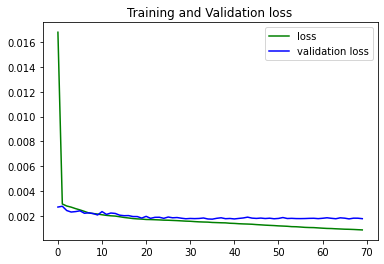

In [33]:
loss_train = history.history["loss"]
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')

plt.legend()
plt.show()

In [34]:
simpleRNN_model = tf.keras.models.load_model('PretrainedModel/SimpleRNN_smoothed_NDVI_only_linear_activation_flatten.h5')
simpleRNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 541)         6155498   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 541)         585903    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10836)       5873112   
Total params: 12,614,513
Trainable params: 12,614,513
Non-trainable params: 0
_________________________________________________________________


In [35]:
# create test dataset using the remaining 25% data 
test_data_input = []
test_data_label = []

for sample_i in range(training_size, ndvi.count):
    
    test_data_label.append(smoothed_dataset[sample_i,:,:,0])
    this_initial_sequence = []
    for t in range(sample_i-15,sample_i): # each sample has 15 time steps
        this_initial = smoothed_dataset[t,:,:,0]
        #this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
    test_data_input.append(this_initial_sequence)
    
    
test_data_input = np.asarray(test_data_input)
test_data_label = np.asarray(test_data_label)


In [36]:
print(test_data_input.shape)
print(test_data_label.shape)

(187, 15, 172, 63)
(187, 172, 63)


In [37]:
test_data_input = test_data_input.reshape((187,15,172*63))
#test_data_label = test_data_label.reshape(187,172,63)
#test_data_label = test_data_label.reshape(187,172*63)

In [38]:
print(test_data_input.shape)
print(test_data_label.shape)

(187, 15, 10836)
(187, 172, 63)


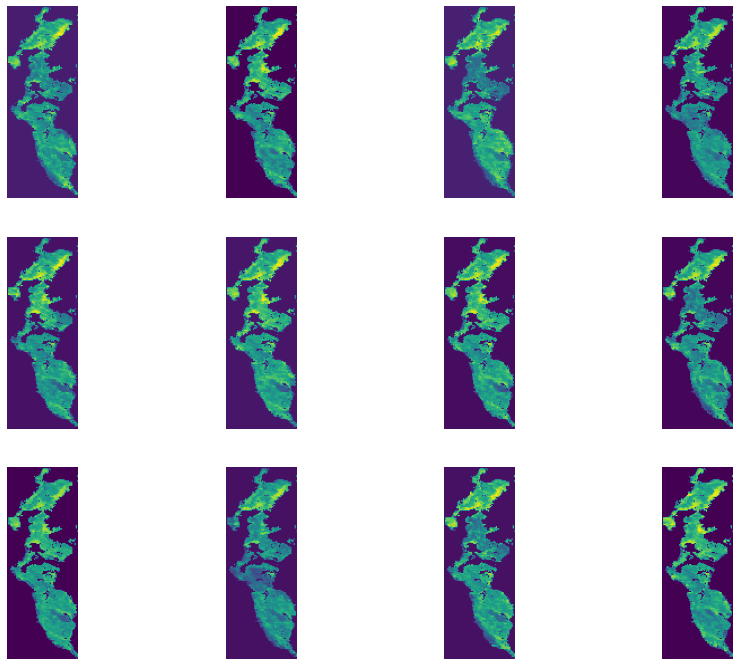

In [39]:
# visualize random 12 test label
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,187)
    plt.imshow(test_data_label[random_time])
    plt.axis('off')

In [40]:
# Test the model performance based on the generated test data

predicted = simpleRNN_model.predict(test_data_input) 


predicted = predicted[::, -1, ::]  

print(np.shape(predicted))
"""
predicted = predicted[::, -1, ::, ::, ::]  
predicted = predicted[:,:,:,0] 
print("the shape of predicted data is " + str(predicted.shape))
"""

(187, 10836)


'\npredicted = predicted[::, -1, ::, ::, ::]  \npredicted = predicted[:,:,:,0] \nprint("the shape of predicted data is " + str(predicted.shape))\n'

In [41]:
predicted = predicted.reshape((187,172,63))
#test_data_label = test_data_label.reshape((187,172,63))

In [42]:
#np.shape(predicted)
np.shape(predicted)

(187, 172, 63)

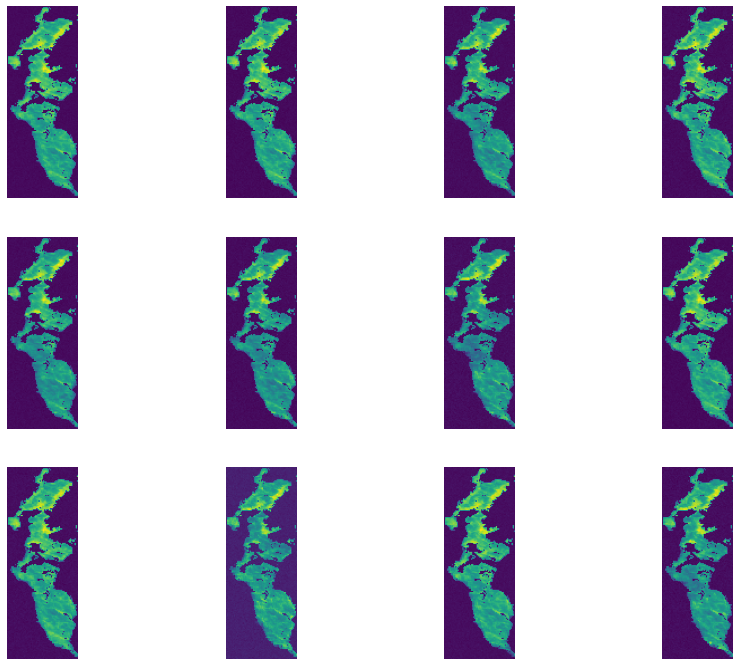

In [43]:
# Visualize some predicted NDVI
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,187)
    plt.imshow(predicted[random_time])
    plt.axis('off')
    

In [44]:
# find the valid test pixels for RMSE calculation

valid_testlabel = []
valid_predicted = []


for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):

            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel.append(test_data_label[i-561,m,n])
                valid_predicted.append(predicted[i-561,m,n])

print(np.shape(valid_testlabel))
print(np.shape(valid_predicted))

(421377,)
(421377,)


In [45]:
# Performance of the ConvLSTM model
from sklearn.metrics import mean_squared_error
rmse =  mean_squared_error(valid_testlabel, valid_predicted, squared=False)
rmse


0.07991482632107126

In [46]:
#pip install sklearn

In [47]:
import sklearn
from sklearn import metrics
r2 = sklearn.metrics.r2_score(valid_testlabel,valid_predicted)
print(r2)

0.5655607167186578


In [48]:
"""
predicted = predicted[:,-1,:]
predicted_reshape = predicted.reshape((187,172,63))
"""

'\npredicted = predicted[:,-1,:]\npredicted_reshape = predicted.reshape((187,172,63))\n'

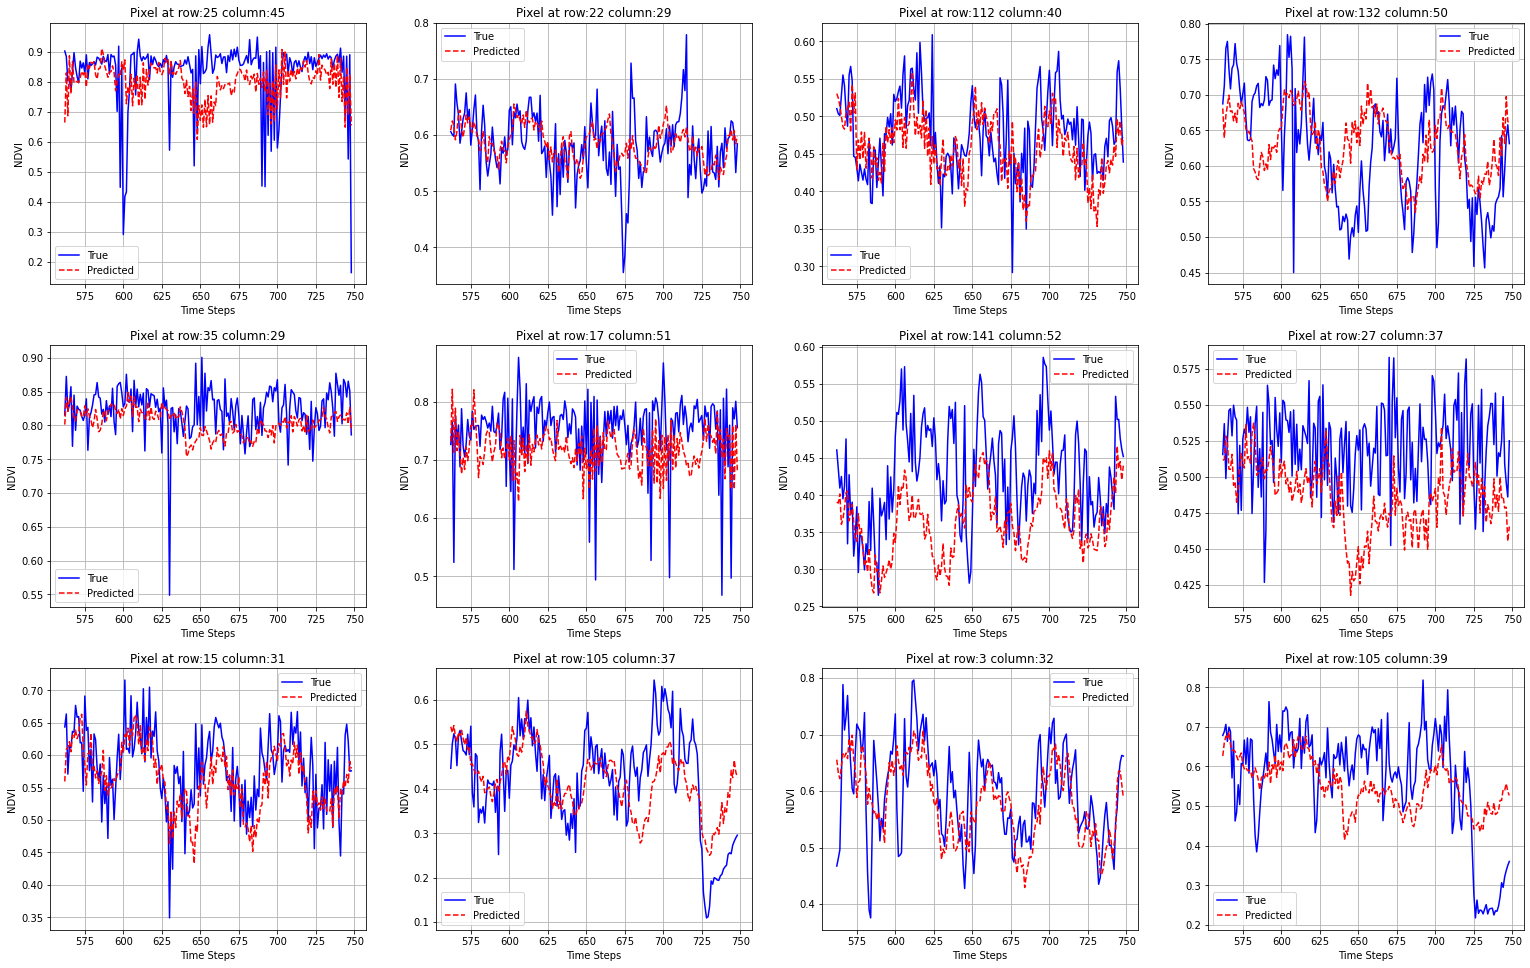

In [49]:
# Visualize the predictions of 12 pixels
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    #for j in range(1,3):

    plt.subplot(3,4,i)

    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    true_series = test_data_label[:,pixel_y,pixel_x]   
    predict_series = predicted[:,pixel_y,pixel_x]
    plt.plot(time_steps, true_series,"b-", label='True')
    plt.plot(time_steps, predict_series,"r--", label='Predicted')
    #plt.ylim(0.0,1.0)
    plt.xlabel("Time Steps")
    plt.ylabel("NDVI")
    plt.legend()
    plt.grid('on')
    plt.title('Pixel at row:'+str(pixel_y)+" column:"+str(pixel_x))

In [50]:
predicted_reshape = predicted

(-0.5, 62.5, 171.5, -0.5)

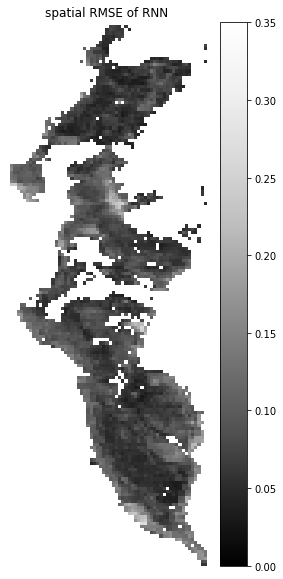

In [51]:
# calculate per pixel rmse
test_data_label_reshape = test_data_label.reshape((187,172,63))
spatial_rmse = np.random.rand(ndvi.height,ndvi.width)

for i in range(ndvi.height):
    for j in range(ndvi.width):
        this_true = test_data_label_reshape[:,i,j]
        this_predict = predicted_reshape[:,i,j]
        this_rmse = mean_squared_error(this_true,this_predict, squared=False)

        spatial_rmse[i,j] = this_rmse

spatial_rmse_masked = np.empty(shape=np.shape(covariates_arr))

spatial_rmse_masked = mask_layer(spatial_rmse,study_region_mask)


for m in range(172):
    for n in range(63):
        if spatial_rmse_masked[m,n] == 0:
            spatial_rmse_masked[m,n] = np.nan
        else:
            pass
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.35) 
plt.figure(figsize=(5,10))
plt.title("spatial RMSE of RNN")
plt.imshow(spatial_rmse_masked, cmap="Greys_r", norm=norm)
plt.colorbar()
plt.axis("off")
#plt.savefig("spatial RMSE of RNN new.png", dpi = 1320)

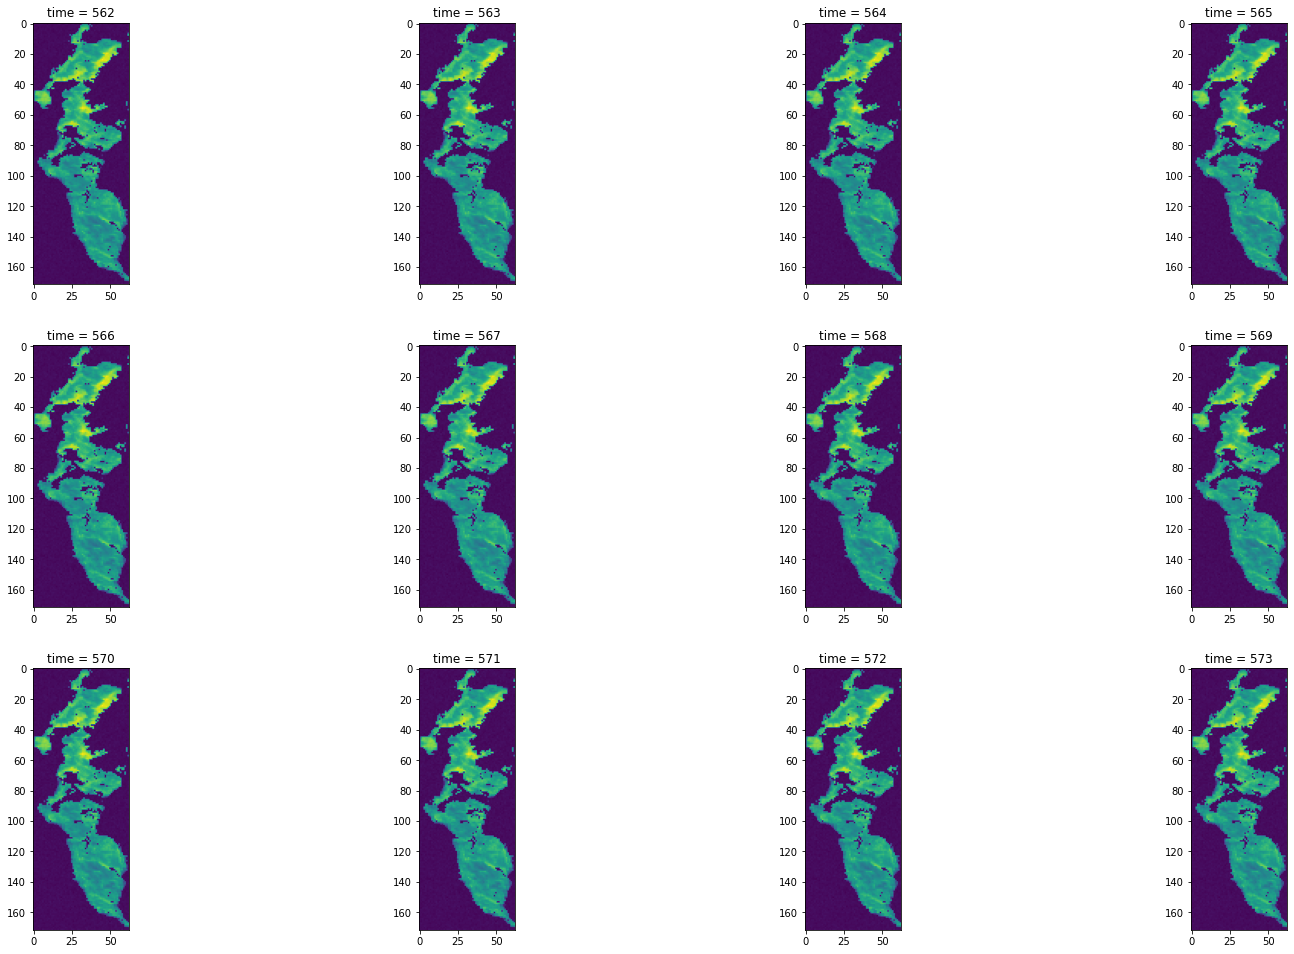

In [52]:
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    plt.subplot(3,4,i)
    #for j in range(1,3):
    predict_series = predicted[j]

    plt.imshow(predict_series)
        #plt.ylim(0.0,1.0)
    plt.title("time = " + str(561+i))

In [53]:
# calculate temporal rmse of 12 randomly picked pixels
x = []
y = []
for j in range(1,13):
    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    x.append(pixel_x)
    y.append(pixel_y)

    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,pixel_y,pixel_x] == 0 and ndvi_arr[i,pixel_y,pixel_x] > 0:
            tem_label.append(test_data_label[i-561,pixel_y,pixel_x])
            tem_pred.append(predicted[i-561,pixel_y,pixel_x])

    tem_rmse =  mean_squared_error(tem_label, tem_pred, squared=False)
    print("the temporal RMSE of pixel (" + str(pixel_y) + "," + str(pixel_x) +") " + "is " + str(tem_rmse))

the temporal RMSE of pixel (110,43) is 0.05206036093848418
the temporal RMSE of pixel (11,28) is 0.06830368661840992
the temporal RMSE of pixel (148,39) is 0.057194290840039956
the temporal RMSE of pixel (108,32) is 0.0444720758148081
the temporal RMSE of pixel (125,32) is 0.06806536201847234
the temporal RMSE of pixel (161,51) is 0.08104848590803629
the temporal RMSE of pixel (22,42) is 0.06665933522224209
the temporal RMSE of pixel (150,37) is 0.06270831373480085
the temporal RMSE of pixel (125,31) is 0.05480440180218868
the temporal RMSE of pixel (64,56) is 0.06381655080575138
the temporal RMSE of pixel (157,46) is 0.05829680171084009
the temporal RMSE of pixel (159,47) is 0.08389420668921128


In [54]:
# calculate temporal r2 of 12 randomly picked pixels
for j in range(1,13):


    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,y[j-1],x[j-1]] == 0 and ndvi_arr[i,y[j-1],x[j-1]] > 0:
            tem_label.append(test_data_label[i-561,y[j-1],x[j-1]])
            tem_pred.append(predicted[i-561,y[j-1],x[j-1]])
    tem_r2 = sklearn.metrics.r2_score(tem_label,tem_pred)
    
    print("the temporal R2 of pixel (" + str(y[j-1]) + "," + str(x[j-1]) +") " + "is " + str(tem_r2))

the temporal R2 of pixel (110,43) is 0.17674543607345805
the temporal R2 of pixel (11,28) is -0.44155925249988615
the temporal R2 of pixel (148,39) is 0.031738577798914536
the temporal R2 of pixel (108,32) is 0.392368874694335
the temporal R2 of pixel (125,32) is -1.1160067791293966
the temporal R2 of pixel (161,51) is -1.319424623307769
the temporal R2 of pixel (22,42) is -1.4200872824264317
the temporal R2 of pixel (150,37) is 0.42826358503499284
the temporal R2 of pixel (125,31) is -0.41293320584559945
the temporal R2 of pixel (64,56) is 0.2767409277966686
the temporal R2 of pixel (157,46) is 0.33932003528785826
the temporal R2 of pixel (159,47) is -1.266351083583543


In [55]:
# calculate per pixel rmse
spatial_rmse = np.random.rand(ndvi.height,ndvi.width)

for i in range(ndvi.height):
    for j in range(ndvi.width):
        this_true = test_data_label[:,i,j]
        this_predict = predicted[:,i,j]
        this_rmse = mean_squared_error(this_true,this_predict, squared=False)
        spatial_rmse[i,j] = this_rmse

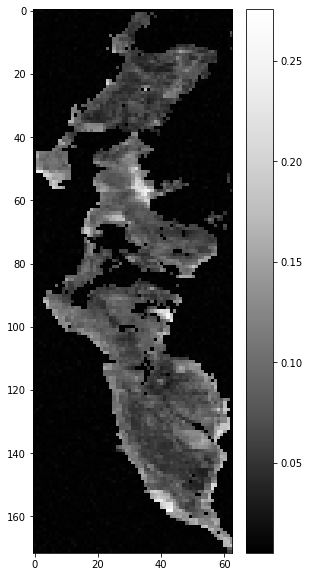

In [56]:
plt.figure(figsize=(5,10))
plt.imshow(spatial_rmse, cmap="Greys_r")
plt.colorbar()